### 课程实验三：学号识别

- 任务输入：学号照片
- 任务输出：学号数字序列
- 训练集：MNIST（本地已缓存）
- 目标：构建并训练手写数字识别模型，完成学号照片的数字识别与可视化分析。


#### 整体思路与数据准备
训练：使用 MNIST 28×28 训练轻量 CNN。
推理：与 predict_id.py 相同的 OpenCV 流程——灰度+高斯模糊→Otsu 二值/可选反色→形态学闭操作去噪→Canny 行列投影粗裁剪→轮廓外接矩形分割，若轮廓不足则列投影切分连体→裁空白、方形填充、缩放到 28×28→按 MNIST 均值方差归一化→模型逐位预测并可视化。


In [1]:
# 依赖引入与运行环境设置
import os, time, random, math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import cv2

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_root = "data"
print(f"Using device: {device}")

Using device: cuda


#### MNIST 加载与划分策略
使用本地缓存的 MNIST，按 9:1 划分验证集，统一标准化。


In [2]:
# 加载 MNIST 数据集并划分训练/验证/测试集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_full = datasets.MNIST(root=data_root, train=True, transform=transform, download=False)
test_ds = datasets.MNIST(root=data_root, train=False, transform=transform, download=False)
val_size = 10000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(42))

batch_size = 128
loader_kwargs = dict(batch_size=batch_size, num_workers=2, pin_memory=True)
train_loader = DataLoader(train_ds, shuffle=True, **loader_kwargs)
val_loader = DataLoader(val_ds, shuffle=False, **loader_kwargs)
test_loader = DataLoader(test_ds, shuffle=False, **loader_kwargs)

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")

Train/Val/Test sizes: 50000/10000/10000


#### 样本可视化与分布检查
查看样本与像素分布，确认灰度范围。


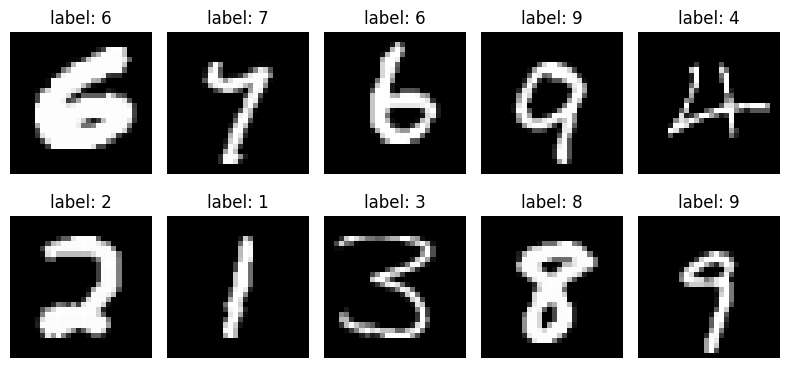

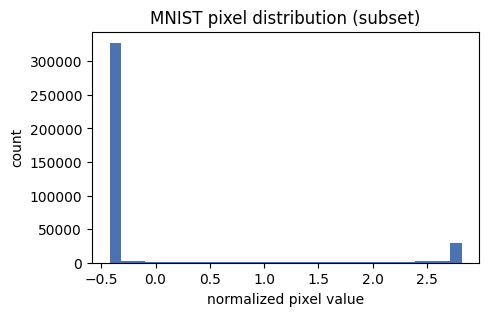

In [3]:
# 可视化样本与像素分布
fig, axes = plt.subplots(2, 5, figsize=(8, 4))
for ax, idx in zip(axes.flat, range(10)):
    img, label = train_ds[idx]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"label: {label}")
    ax.axis("off")
plt.tight_layout()
plt.show()

subset = torch.stack([train_ds[i][0] for i in range(512)], dim=0)
pixels = subset.numpy().ravel()
plt.figure(figsize=(5, 3))
plt.hist(pixels, bins=30, color="#4C72B0")
plt.xlabel("normalized pixel value")
plt.ylabel("count")
plt.title("MNIST pixel distribution (subset)")
plt.show()

#### 模型结构设计
两层卷积+BN+池化的轻量 CNN，末端全连接输出 10 类。


In [4]:
# 定义轻量 CNN 模型并统计可训参数
class MNISTCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = MNISTCNN().to(device)
print(f"Trainable params: {count_params(model):,}")

Trainable params: 421,834


#### 训练超参与优化器
交叉熵 + Adam + 余弦退火，小权重衰减防过拟合。


In [5]:
# 训练超参与优化器/调度器设置
epochs = 8
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
best_path = "mnist_cnn_best.pth"

#### 训练/验证循环与指标记录
封装单轮训练/验证，记录 loss/acc 并保存最佳模型。


In [6]:
# 训练与验证循环，记录指标，保存最佳权重
def run_one_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        if is_train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(is_train):
            logits = model(imgs)
            loss = criterion(logits, labels)
        if is_train:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val_acc = 0.0

for epoch in range(1, epochs + 1):
    t0 = time.time()
    tr_loss, tr_acc = run_one_epoch(model, train_loader, optimizer)
    val_loss, val_acc = run_one_epoch(model, val_loader)
    scheduler.step()
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {val_loss:.4f} acc {val_acc:.4f} | {(time.time()-t0):.1f}s")

print(f"Best val acc: {best_val_acc:.4f}, weights saved to {best_path}")

Epoch 01 | train loss 0.1344 acc 0.9582 | val loss 0.0519 acc 0.9840 | 19.2s
Epoch 02 | train loss 0.0484 acc 0.9853 | val loss 0.0491 acc 0.9859 | 18.9s
Epoch 03 | train loss 0.0301 acc 0.9902 | val loss 0.0379 acc 0.9899 | 18.6s
Epoch 04 | train loss 0.0226 acc 0.9924 | val loss 0.0372 acc 0.9895 | 19.4s
Epoch 05 | train loss 0.0148 acc 0.9951 | val loss 0.0298 acc 0.9926 | 16.3s
Epoch 06 | train loss 0.0093 acc 0.9971 | val loss 0.0310 acc 0.9918 | 15.0s
Epoch 07 | train loss 0.0061 acc 0.9982 | val loss 0.0279 acc 0.9927 | 13.5s
Epoch 08 | train loss 0.0044 acc 0.9987 | val loss 0.0269 acc 0.9920 | 13.7s
Best val acc: 0.9927, weights saved to mnist_cnn_best.pth


#### 学习曲线可视化
绘制训练/验证损失与准确率曲线，观察收敛。


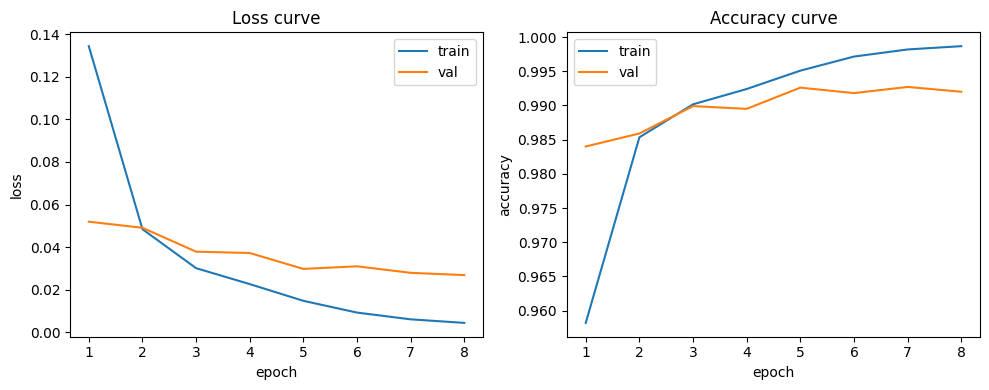

In [7]:
# 绘制训练/验证 loss、acc 曲线
epochs_axis = range(1, epochs + 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_axis, history["train_loss"], label="train")
plt.plot(epochs_axis, history["val_loss"], label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Loss curve")

plt.subplot(1, 2, 2)
plt.plot(epochs_axis, history["train_acc"], label="train")
plt.plot(epochs_axis, history["val_acc"], label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracy curve")
plt.tight_layout()
plt.show()

#### 测试集评估与报告
加载最佳权重，输出分类报告。


In [8]:
# 在测试集上评估并输出分类报告
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

report = classification_report(all_labels, all_preds, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9939    0.9969    0.9954       980
           1     0.9956    0.9965    0.9960      1135
           2     0.9932    0.9922    0.9927      1032
           3     0.9960    0.9931    0.9945      1010
           4     0.9929    0.9939    0.9934       982
           5     0.9856    0.9944    0.9900       892
           6     0.9968    0.9896    0.9932       958
           7     0.9893    0.9932    0.9913      1028
           8     0.9959    0.9928    0.9943       974
           9     0.9911    0.9881    0.9896      1009

    accuracy                         0.9931     10000
   macro avg     0.9930    0.9931    0.9930     10000
weighted avg     0.9931    0.9931    0.9931     10000



#### 混淆矩阵可视化
展示类别混淆情况。


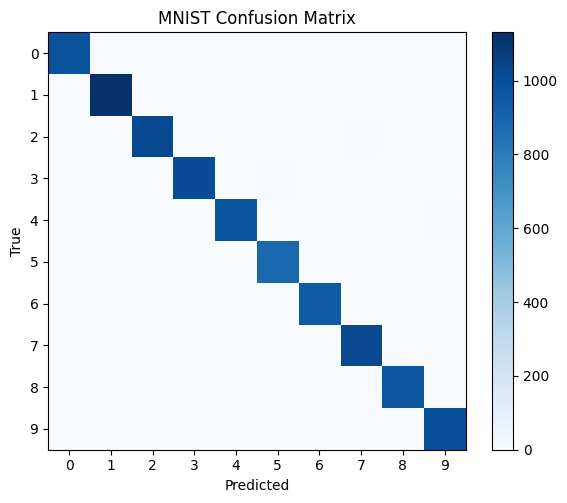

In [9]:
# 绘制混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap="Blues")
ax.figure.colorbar(im, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(range(10))
ax.set_yticks(range(10))
ax.set_title("MNIST Confusion Matrix")
plt.tight_layout()
plt.show()

#### 学号图片预处理与分割策略（与 predict_id.py 一致）
OpenCV 流程：灰度+高斯模糊→Otsu 二值/反色→形态学闭操作→Canny 行列投影粗定位→轮廓外接矩形分割，若轮廓不足则列投影切分连体→裁空白、方形填充、缩放到 28×28 → MNIST 均值方差归一化。可通过 invert/min_area/pad/min_width 参数微调。


In [10]:
# 学号图片分割预处理（与 predict_id.py 一致）
def segment_id_image(path, invert=True, min_area=60, pad=6, min_width=8):
    """
    OpenCV 分割流程：灰度+高斯模糊→Otsu 二值/反色→形态学闭操作→Canny 行列投影粗裁剪→轮廓外接矩形分割；
    若轮廓不足则列投影切分连体。每段裁空白、方形填充、缩放到 28×28，并按 MNIST 均值方差归一化。
    参数可调：invert、min_area、pad、min_width。
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"File not found: {path}")
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    thresh_mode = cv2.THRESH_BINARY_INV if invert else cv2.THRESH_BINARY
    _, binary = cv2.threshold(blur, 0, 255, thresh_mode + cv2.THRESH_OTSU)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)
    edges = cv2.Canny(blur, 100, 200)
    # 行列投影粗定位，裁掉多余背景
    rows_on = np.where(edges.sum(axis=1) > 0)[0]
    cols_on = np.where(edges.sum(axis=0) > 0)[0]
    if rows_on.size and cols_on.size:
        y0, y1 = rows_on[[0, -1]]
        x0, x1 = cols_on[[0, -1]]
        binary = binary[max(0, y0 - 5):min(img.shape[0], y1 + 5), max(0, x0 - 5):min(img.shape[1], x1 + 5)]
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if w * h < min_area or h < 8:
            continue
        boxes.append((x, y, w, h))
    boxes = sorted(boxes, key=lambda b: b[0])

    # 若轮廓不足，按列投影切分连体字符
    def split_by_projection(mask):
        col = (mask.sum(axis=0) > 0).astype(np.uint8)
        segs, s = [], None
        for i, v in enumerate(col):
            if v and s is None:
                s = i
            if not v and s is not None:
                if i - s >= min_width:
                    segs.append((s, i))
                s = None
        if s is not None and len(col) - s >= min_width:
            segs.append((s, len(col)))
        return segs

    norm = transforms.Normalize((0.1307,), (0.3081,))
    processed = []
    if boxes:
        segments = [(x, y, x + w, y + h) for x, y, w, h in boxes]
    else:
        segments = [(l, 0, r, binary.shape[0]) for l, r in split_by_projection(binary)]

    for x0, y0, x1, y1 in segments:
        x0 = max(0, x0 - pad)
        y0 = max(0, y0 - pad)
        x1 = min(binary.shape[1], x1 + pad)
        y1 = min(binary.shape[0], y1 + pad)
        digit = binary[y0:y1, x0:x1]
        if digit.sum() == 0:
            continue
        rows = digit.sum(axis=1) > 0
        cols = digit.sum(axis=0) > 0
        digit = digit[rows][:, cols]
        h, w = digit.shape
        side = max(h, w) + 8
        canvas = np.zeros((side, side), dtype=np.uint8)
        y_off = (side - h) // 2
        x_off = (side - w) // 2
        canvas[y_off:y_off + h, x_off:x_off + w] = digit
        pil = Image.fromarray(canvas)
        pil = pil.resize((28, 28), Image.BILINEAR)
        tensor = transforms.ToTensor()(pil)
        tensor = norm(tensor)
        processed.append((pil, tensor))
    return processed

print("Segmentation helper ready. Example usage: segment_id_image('my_id.jpg')")


Segmentation helper ready. Example usage: segment_id_image('my_id.jpg')


#### 学号预测与展示（与 predict_id.py 同步）
默认使用 `my_id.jpg`，可改路径；分割参数与脚本一致，可按需调整。


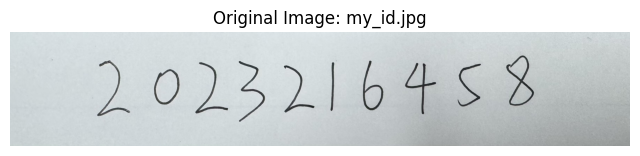

识别学号： 2023216458
分割位数： 10 


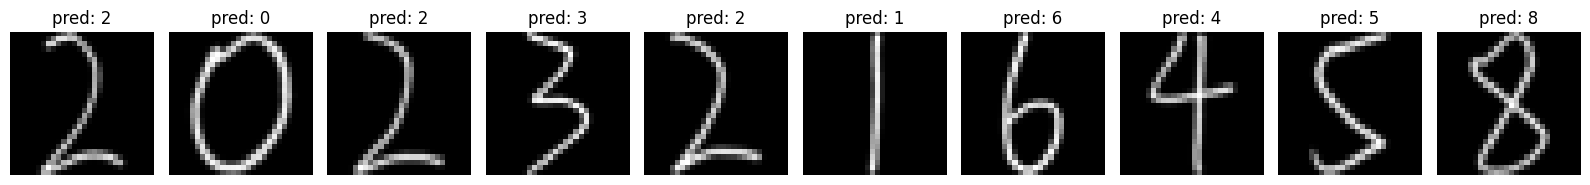

In [17]:
# 调用分割与模型推理学号，并可视化每位预测结果
def predict_digits(model, digits, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for _, tensor in digits:
            logit = model(tensor.unsqueeze(0).to(device))
            preds.append(str(logit.argmax(dim=1).item()))
    return ''.join(preds)

id_path = 'my_id.jpg' 
original_img = Image.open(id_path)
plt.figure(figsize=(8, 4))
plt.imshow(original_img)
plt.title(f'Original Image: {id_path}')
plt.axis('off')
plt.show() # 显示原图
digits = segment_id_image(id_path, invert=True, min_area=60, pad=6, min_width=8)
if not digits:
    print('未检测到数字，尝试调整 --invert/--min-area/--pad/--min-width。')
else:
    id_number = predict_digits(model, digits, device)
    print(f'识别学号： {id_number}')
    print(f'分割位数： {len(digits)} ')

    cols = len(digits)
    fig, axes = plt.subplots(1, cols, figsize=(1.6 * cols, 2))
    if cols == 1:
        axes = [axes]
    for ax, (pil_img, digit_char) in zip(axes, zip([p[0] for p in digits], id_number)):
        ax.imshow(pil_img, cmap='gray')
        ax.set_title(f'pred: {digit_char}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
